## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [121]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
#from sklearn.metrics import plot_roc_curve


import warnings
warnings.filterwarnings("ignore")

#!pip install swifter
import swifter #multi-threading/processing

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier


In [122]:

# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [123]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [124]:
cd '/content/drive/My Drive/Colab Notebooks/Ticket assignment'

/content/drive/My Drive/Colab Notebooks/Ticket assignment


In [125]:

# Opening JSON file  
with open("complaints.json", "r") as complaints_file:
   data = json.load(complaints_file)
   df=pd.json_normalize(data)

## Data preparation

In [126]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [127]:
#print the shape of the dataframe
df.shape

(78313, 22)

In [128]:
#print the frist 10 rows
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [129]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [131]:
#Dropping columns which have just only one unique value in it.
df.drop(columns=['_index','_type','_score','_source.company','_id'],inplace=True,axis=1)

In [132]:
df.columns

Index(['_source.tags', '_source.zip_code', '_source.complaint_id',
       '_source.issue', '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [133]:
#Assign new column names
new_col_name = [col.split('.')[1] for col in df.columns]
df.set_axis(new_col_name,axis=1,inplace=True)
df.columns


Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product',
       'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')

In [134]:
df.columns

Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product',
       'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')

In [135]:

df.complaint_what_happened.isnull().sum() # this should have been find blank space

0

In [136]:
#Assign nan in place of blanks in the complaints column

df[df.loc[:, 'complaint_what_happened'] == '']= np.nan



In [137]:
df.complaint_what_happened.isnull().sum()

57241

In [138]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]


In [139]:
df.shape

(21072, 17)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [140]:
df.complaint_what_happened

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [141]:
# Write your function here to clean the text and remove all the unnecessary elements.

In [142]:
# this function get one input from df.complaints --> makes it to str and then removes everthing

def clean_text(complaint):
  text=str(complaint)
  text = text.lower()
  text= re.sub("\(.*?\)","()",text)
  text= re.sub("\[.*?\]","[]",text)
  text = re.sub(r'[^\w\s]','',text)
  text= re.sub("\S*\d\S*", "", text).strip()
  return text



In [143]:
clean_complaints = df.complaint_what_happened.swifter.apply(clean_text)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [144]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)



In [145]:
lemmatize_complaints =clean_complaints.swifter.apply(lemmmatize_text)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [146]:
#lemmatize_complaints

In [147]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(data={'complaints': clean_complaints, 'lemmatized': lemmatize_complaints})

In [148]:
df_clean

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...


In [149]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  sent=[]
  tokens =nlp(text)
  sent = [str(token) for token in tokens if token.tag_=="NN"]
  return " ".join(sent)




In [150]:
df_clean["complaint_POS_removed"]= df_clean['lemmatized'].swifter.apply(pos_tag)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [151]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




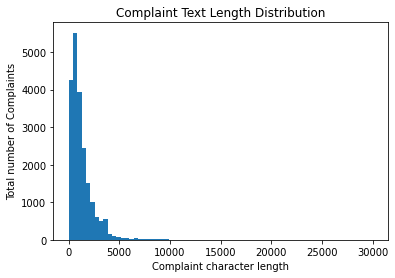

In [152]:
# Write your code here to visualise the data according to the 'Complaint' character length

character_length=[len(complaint) for complaint in df_clean['complaints']]
plt.hist(character_length,bins=70)

plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Complaint Text Length Distribution")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

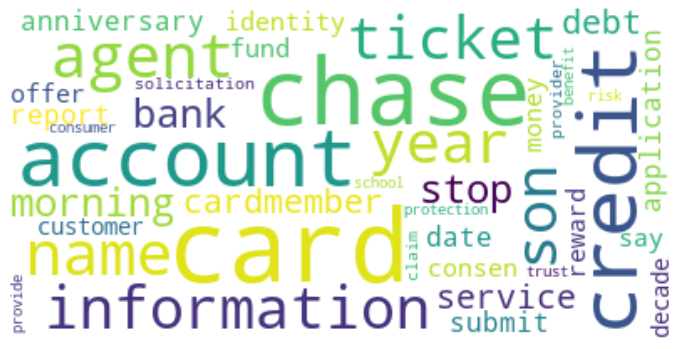

In [153]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [154]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


In [155]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application submit identity consen...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [156]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]



In [157]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,44951
1,chase,39514
2,credit,32352
3,card,29564
4,payment,20501
5,charge,15878
6,bank,15833
7,time,15672
8,day,12463
9,money,11811


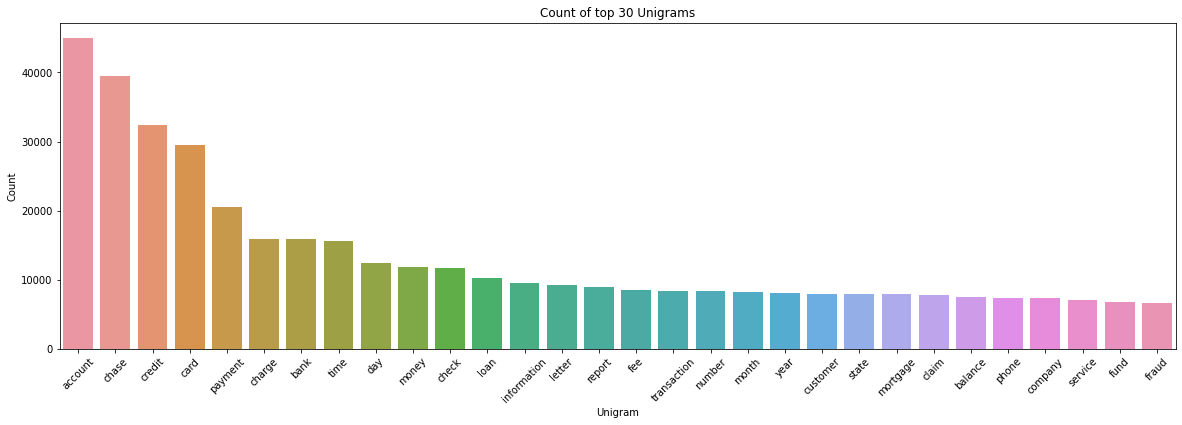

In [158]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [159]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,44951
1,chase,39514
2,credit,32352
3,card,29564
4,payment,20501
5,charge,15878
6,bank,15833
7,time,15672
8,day,12463
9,money,11811


In [160]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12346
1,credit report,3866
2,customer service,2843
3,account account,2520
4,chase credit,2403
5,account chase,2373
6,bank account,1952
7,debit card,1831
8,chase account,1829
9,check account,1814


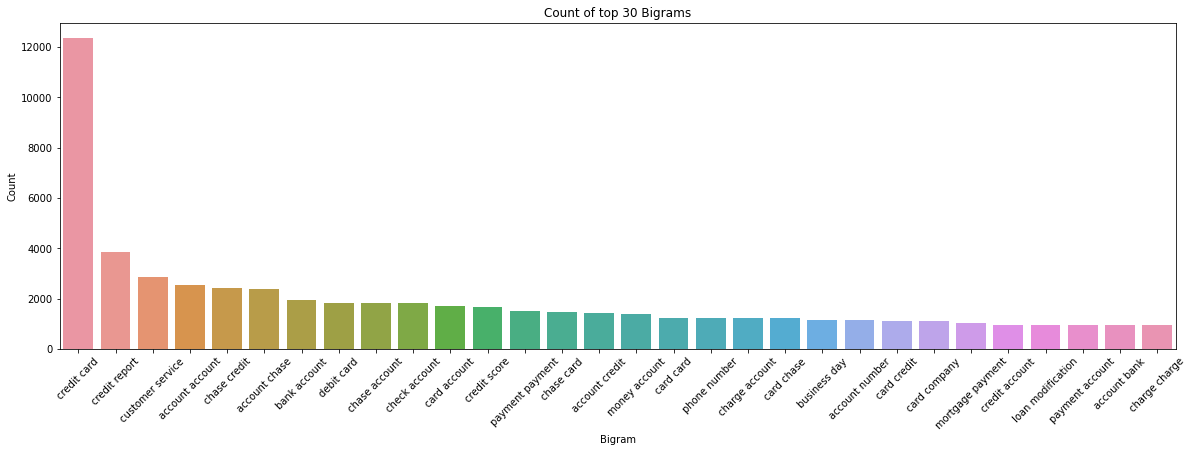

In [161]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [162]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12346
1,credit report,3866
2,customer service,2843
3,account account,2520
4,chase credit,2403
5,account chase,2373
6,bank account,1952
7,debit card,1831
8,chase account,1829
9,check account,1814


In [163]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,1689
1,credit card account,1080
2,credit card company,948
3,credit card credit,549
4,credit card chase,539
5,charge credit card,529
6,inquiry credit report,514
7,card credit card,448
8,account credit card,437
9,credit card charge,360


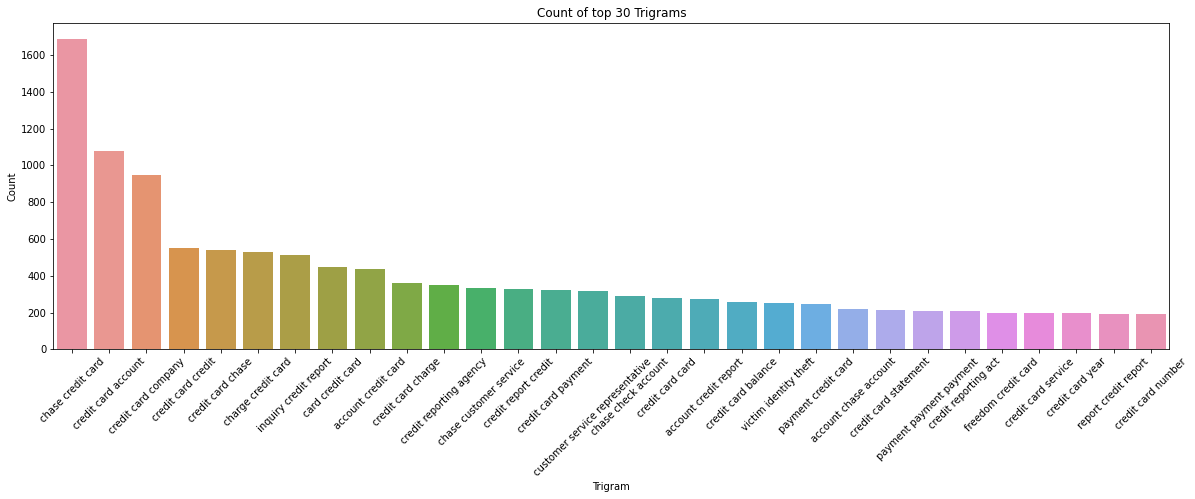

In [164]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [165]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,1689
1,credit card account,1080
2,credit card company,948
3,credit card credit,549
4,credit card chase,539
5,charge credit card,529
6,inquiry credit report,514
7,card credit card,448
8,account credit card,437
9,credit card charge,360


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [166]:
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [167]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application submit identity consen...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [168]:
#Write your code here to initialise the TfidfVectorizer #Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [169]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = tfidf.fit_transform(df_clean['Complaint_clean'])


In [170]:
X

<21072x6389 sparse matrix of type '<class 'numpy.float64'>'
	with 610516 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [171]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [172]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [173]:
nmf_model.fit(X)
len(tfidf.get_feature_names())

6389

In [174]:
H = nmf_model.components_       # Topic-term matrix

In [175]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,chase,deposit,branch,day,pron,number,transaction,business,transfer,claim
Topic 2,credit,card,report,inquiry,chase,account,score,company,information,limit,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,pay,time,date,auto,chase,credit,account,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,purchase,claim,fraud,service,refund,time,statement,balance
Topic 5,loan,mortgage,modification,home,chase,property,year,letter,time,document,rate,sale,foreclosure,house,request


#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_mapping = {
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 1': 'Bank account services',
    'Topic 2': 'Theft/Dispute reporting',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Others'
    

In [176]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(X)
topic_results

array([[0.02258586, 0.0114356 , 0.00858697, 0.00631808, 0.02015335],
       [0.00843225, 0.01241486, 0.00169701, 0.00837215, 0.00623719],
       [0.        , 0.05788042, 0.        , 0.        , 0.        ],
       ...,
       [0.01127021, 0.01648781, 0.        , 0.01825933, 0.007694  ],
       [0.        , 0.05076694, 0.10365419, 0.02406396, 0.        ],
       [0.02374165, 0.03442904, 0.09891351, 0.00501843, 0.        ]])

In [177]:
len(topic_results)

21072

In [178]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [179]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application submit identity consen...,card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0


In [180]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,notice account card branch customer service re...,notice account card branch customer service re...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account,mishandle account,0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application submit identity consen...,card report application submit identity consen...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company help i...,chase credit card credit report company help i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [181]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [182]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [183]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [184]:
df_clean.shape

(21072, 5)

In [185]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints', 'Topic']]

In [186]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


In [187]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [188]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train = vect.fit_transform(training_data['complaints'])

In [189]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

Logistic regression

In [190]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [191]:
lr = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [192]:
# Getting the score of the base model
lr.score(X_test, y_test)

0.9166666666666666



HyperParameter Tuning

In [193]:

lr_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}


# Setup grid hyperparameter search for LogisticRegression
lr_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=lr_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
lr_hpt.fit(X_train, y_train);                

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [194]:
# Check best parameters
lr_hpt.best_params_

{'C': 3, 'solver': 'liblinear'}

In [195]:
# Evaluating the tuned model
lr_hpt.score(X_test, y_test)

0.9229309035687168

In [196]:
# Make predictions on test data
y_pred = lr_hpt.predict(X_test)


In [197]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [198]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.93      0.92      1320
Credit card / Prepaid card       0.92      0.95      0.93      1299
                    Others       0.93      0.89      0.91       548
   Theft/Dispute reporting       0.92      0.90      0.91      1152
           Mortgages/loans       0.93      0.93      0.93       949

                  accuracy                           0.92      5268
                 macro avg       0.92      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



Desision tree

In [199]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [200]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7737281700835231

HyperParameter Tuning

In [201]:
dt_grid = {"max_depth": [3, 10, 15, 20],
           "min_samples_split": np.arange(2, 20, 5),
           "min_samples_leaf": np.arange(1, 20, 5)}

In [202]:
# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [203]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 2}

In [204]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.8008731966590736

In [205]:
# Make predictions on test data
y_pred = dt_hpt.predict(X_test)

In [206]:

# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.81      0.81      0.81      1320
Credit card / Prepaid card       0.83      0.85      0.84      1299
                    Others       0.80      0.74      0.77       548
   Theft/Dispute reporting       0.77      0.74      0.75      1152
           Mortgages/loans       0.78      0.84      0.81       949

                  accuracy                           0.80      5268
                 macro avg       0.80      0.79      0.80      5268
              weighted avg       0.80      0.80      0.80      5268



Random Forest Classifier

In [207]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [208]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8168185269552012

Hyper parameter tuning

In [209]:
rf_grid = {"n_estimators": np.arange(10, 1000, 100),
           "max_depth": [5, 10, 15],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [210]:
# Setup random hyperparameter search for LogisticRegression
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [215]:
# Check best parameters
rf_hpt.best_params_

{'max_depth': 15,
 'min_samples_leaf': 13,
 'min_samples_split': 14,
 'n_estimators': 810}

In [216]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7446848899012908

In [217]:
# Make predictions on test data
y_pred = rf_hpt.predict(X_test)

In [218]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.75      0.89      0.81      1320
Credit card / Prepaid card       0.66      0.87      0.75      1299
                    Others       1.00      0.04      0.07       548
   Theft/Dispute reporting       0.80      0.75      0.77      1152
           Mortgages/loans       0.85      0.77      0.80       949

                  accuracy                           0.74      5268
                 macro avg       0.81      0.66      0.64      5268
              weighted avg       0.78      0.74      0.71      5268



Gaussian Naive Bayes

In [219]:
# Training the Naive Bayes model on the Training set

gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)


GaussianNB()

In [220]:
gnb.score(X_test.toarray(), y_test)

0.3437737281700835

In [221]:
# Predicting the Test set results
y_pred = gnb.predict(X_test.toarray())


In [222]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.44      0.28      0.34      1320
Credit card / Prepaid card       0.38      0.32      0.35      1299
                    Others       0.15      0.45      0.22       548
   Theft/Dispute reporting       0.43      0.31      0.36      1152
           Mortgages/loans       0.50      0.45      0.47       949

                  accuracy                           0.34      5268
                 macro avg       0.38      0.36      0.35      5268
              weighted avg       0.40      0.34      0.36      5268



##Results
The results of the four models are as follows:
###Logistic Regression
- The overall accuracy of the Logistic Regression model is 92%.
- Precision and Recall are 92% and 92% respectively which makes this is a very good model.

###Decision Tree
- The overall accuracy of the Decision Tree model is 80%
- Precision and Recall are 80% and 79% respectively

###Random Forest
- The overall accuracy of the Random Forest model is 74%
- Precision and Recall are 81% and 66% respectively and genrally indicates overfitting

###Naive Bayes
- The overall accuracy of the Naive Bayes model is 36%
- Precision and Recall are 38% and 36% respectively 

Based on the above results, Logistic Regression is the best model with an accuracy of 92% with Precision and Recall as 92% and 92% respectively

## Custom text

In [253]:
custom=vect.transform(['My Chase credit card which is incorrectly reporting data on my credit report but the company is not helping resolve the issue.'])

In [254]:
custom_tdif=tfidf_transformer.fit_transform(custom)

In [255]:
lr_hpt.predict(custom_tdif)

array([1])

The model ticketed this issue as 1 which stands for "Credit card / Prepaid card